In [1]:
# You may need to remove the '#' from the following commands to install the required dependencies

#these two are to read the excel
#! pip install xlrd
#! pip install install openpyxl

#These are to run R

In [2]:
# Importing libraries
import pandas as pd
import os
import numpy as np

import statsmodels.formula.api as smf
from itertools import combinations

import time

In [3]:
min_repetitions=2

In [4]:
#One row per cell line
x = pd.read_excel('data/ProCan-DepMapSanger_protein_matrix_6692_averaged.xlsx', engine='openpyxl').fillna(0).drop(columns=['Project_Identifier'])
c = [a.replace(';','.') for a in x.columns]
x.columns = c
x.columns

Index(['Cell_Line', 'P37108.SRP14_HUMAN', 'Q96JP5.ZFP91_HUMAN',
       'Q9Y4H2.IRS2_HUMAN', 'P36578.RL4_HUMAN', 'Q6SPF0.SAMD1_HUMAN',
       'O76031.CLPX_HUMAN', 'Q8WUQ7.CATIN_HUMAN', 'A6NIH7.U119B_HUMAN',
       'Q9BTD8.RBM42_HUMAN',
       ...
       'P33151.CADH5_HUMAN', 'Q5EBL4.RIPL1_HUMAN', 'P49715.CEBPA_HUMAN',
       'Q5TA45.INT11_HUMAN', 'O14924.RGS12_HUMAN', 'Q7Z3B1.NEGR1_HUMAN',
       'O60669.MOT2_HUMAN', 'Q13571.LAPM5_HUMAN', 'Q96JM2.ZN462_HUMAN',
       'P35558.PCKGC_HUMAN'],
      dtype='object', length=6693)

In [5]:
y = pd.read_csv('data/DrugResponse_PANCANCER_GDSC1_GDSC2_20200602.csv')[['drug_id','cell_line_name','ln_IC50']]
y.columns

/opt/homebrew/anaconda3/envs/vs05/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (24) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Index(['drug_id', 'cell_line_name', 'ln_IC50'], dtype='object')

In [6]:
# This cell is the function to go from the table to a JSON file (variantSpark format and structure)

def merge_tree_node(tree, node):
    
    # Empty tree
    if type(tree)==float: return tree
    if len(tree)==0: return node

    # Direct children
    if tree['right'] == node['nodeID']:
        tree['right'] = node
        return tree
    elif tree['left'] == node['nodeID']:
        tree['left'] = node
        return tree

    # Create
    right = merge_tree_node(tree['right'], node)
    left = merge_tree_node(tree['left'], node)
    tree['right'] = right
    tree['left'] = left
    return tree
            

def from_table_to_json(m):
    tree = {}
    for _id,row in m.iterrows():
        current_node = {'nodeID': row['nodeID'], 
                        'splitvarID':row['splitvarID'],
                        'splitVar':row['splitvarName'],
                        'splitval':row['splitval'], 
                        'terminal':row['terminal'], 
                        'prediction':row['prediction'], 
                        'left':row['leftChild'], 
                        'right':row['rightChild'] }
        tree = merge_tree_node(tree, current_node)
    return tree



# Test
#m = pd.read_csv('output/tree1.csv')
#from_table_to_json(m)

In [7]:
# Algorithm to get the interacting nodes (no testing done yet)

def get_interactions(tree, current_list, interactions):
    if not 'splitVar' in tree.keys():
        return 0
    if str(tree['splitVar']) == 'nan': return 0 #ranger adds a fake predicting node at the end
    
    # Adding the interaction
    current_list.append(tree['splitVar'])
    if len(current_list) >= 2:
        for i in range(2,len(current_list)+1):
            aux = '+'.join(sorted(current_list[-i:]))
            if aux in interactions.keys():
                interactions[aux] +=1
            else:
                interactions[aux] = 1
                    
    if 'left' in tree.keys():
        get_interactions(tree['left'], current_list, interactions)
    if 'right' in tree.keys():
        get_interactions(tree['right'], current_list, interactions)
        
    _ = current_list.pop()
    

In [8]:
# Testing all the interactions

def test_interactions(df, data):
    """
    I use GLM because:
    The main difference between the two approaches is that the general linear model strictly assumes that
    the residuals will follow a conditionally normal distribution, while the GLM loosens this assumption 
    and allows for a variety of other distributions from the exponential family for the residuals.
    """
    final_results = []
    counts = 0

    for v in df[(df.repetitions>=2) & (df.order ==2)].variants.tolist():
        
        #preparing the input
        sp=v.split('+')
        xy = data[sp+['ln_IC50']].fillna(-1)
        sp=v.replace('_','').split('+')
        xy.columns = [''.join([chr(int(y)+97) if y.isnumeric() else y for y in x.replace('_','').replace('.','')]) for x in xy.columns]
        formula = xy.columns[-1]+' ~ '
        for i in range(1,len(xy.columns)):
            formula = formula + ' + '.join(['*'.join(o) for o in list(combinations(xy.columns[:-1],i))])
            formula = formula + ' + '
        formula = formula.rstrip(' + ')

        # Standard fitting
        ols = smf.ols(formula,data=xy)
        ols.raise_on_perfect_prediction = False #preventing the perfect separation error
        results = ols.fit(disp=False, maxiter=1000) #mehtod prevents singular matrix
        results = results.summary()
        converged = results.tables[0].data[5][1].strip()
        pseudo_r2 = results.tables[0].data[3][3].strip()
        results = results.tables[1].data
        results = pd.DataFrame(results[1:], columns=['coef_id', 'coef', 'std err', 'z', 'P>|z|', '[0.025', '0.975]'])
        results['standard_fitting'] = True

        #If nan means no convergence bc singular matrix
        #adding regularization
        if 'nan' == pd.DataFrame(results)['z'].iloc[2].strip():
            try:
                results = ols.fit_regularized(method='l1', disp=False, maxiter=1000, alpha=0.3) #mehtod prevents singular matrix
                results = results.summary()
                converged = results.tables[0].data[5][1].strip()
                pseudo_r2 = results.tables[0].data[3][3].strip()
                results = results.tables[1].data
                results = pd.DataFrame(results[1:], columns=['coef_id', 'coef', 'std err', 'z', 'P>|z|', '[0.025', '0.975]'])
                results['standard_fitting'] = False        
            except:
                #crashed the regularized
                counts +=1

        results['converged'] = converged
        results['pseudo_r2'] = pseudo_r2
        results['snps'] = v
        results['order'] = len(sp)
        final_results.append(results)

    final_results = pd.concat(final_results)
    #print(counts)
    return final_results

In [9]:
# Testing all the interactions

def results_fit_to_df(results):
    coeffs = results.params.tolist()
    pvals = results.pvalues.tolist()
    pseudo_r2 = results.rsquared
    tvals = results.tvalues.tolist()
    cint_low = results.conf_int()[0].tolist()
    cint_high = results.conf_int()[1].tolist()

    results = results.summary()
    converged = results.tables[0].data[5][1].strip()
    results = results.tables[1].data
    results = pd.DataFrame(results[1:], columns=['coef_id', 'coef', 'std err', 'z', 'P>|z|', '[0.025', '0.975]'])
    results['P>|z|'] = pvals
    results['z'] = tvals 
    results['coef'] = coeffs
    results['converged'] = converged
    results['pseudo_r2'] = pseudo_r2
    results['[0.025'] = cint_low
    results['0.975]'] = cint_high
    return results
    
def test_interactions_high(df, data, max_order=4):
    """
    I use GLM because:
    The main difference between the two approaches is that the general linear model strictly assumes that
    the residuals will follow a conditionally normal distribution, while the GLM loosens this assumption 
    and allows for a variety of other distributions from the exponential family for the residuals.
    """
    final_results = []
    counts = 0

    for m_or in range(2,max_order+1):
        print('current order',m_or)
        
        for v in df[(df.repetitions>=2) & (df.order==m_or)].variants.tolist():
            #preparing the input
            sp=v.split('+')
            xy = data[sp+['ln_IC50']].fillna(-1)
            sp=v.replace('_','').split('+')
            xy.columns = [''.join([chr(int(y)+97) if y.isnumeric() else y for y in x.replace('_','').replace('.','')]) for x in xy.columns]
            formula = xy.columns[-1]+' ~ '
            for i in range(1,len(xy.columns)):
                formula = formula + ' + '.join(['*'.join(o) for o in list(combinations(xy.columns[:-1],i))])
                formula = formula + ' + '
            formula = formula.rstrip(' + ')
            
            #Recreating the formula
            if m_or>2:
                #gathering all interactions
                fs = formula.split(' + ')
                formula = ' + '.join([a for a in fs if '*' not in a]+[a for a in fs if a.count('*')== m_or-1])
                all_interactions = [a.replace('*',':') for a in fs if '*' in a]
                final_results = pd.concat(final_results)
                subset = final_results[final_results.coef_id.apply(lambda a: a in all_interactions)].reset_index(drop=True)
                final_results = [final_results]
                if len(subset)>0:
                    max_idx = subset['coef'].astype(float).idxmax()
                    coef_id = subset.loc[max_idx].coef_id
                    formula = formula +' + '+coef_id.replace(':','*')
                else:
                    #pass
                    continue # bc i dont think it is a valid tree form (interaction-wise)
                    #There is no sub epistasis (P>Q>O>P, tree 503, first compound)

            # Standard fitting
            try:
                ols = smf.ols(formula.replace('*',':'),data=xy)
                # "*" vs ":" #https://stackoverflow.com/questions/33050104/difference-between-the-interaction-and-term-for-formulas-in-statsmodels-ols
            except:
                print('error in OLS')
                print('coef_id',coef_id)
                print('formula OLS',type(formula),formula)
                #return pd.concat(final_results)
                continue
            ols.raise_on_perfect_prediction = False #preventing the perfect separation error
            results = ols.fit(disp=False, maxiter=1000) #mehtod prevents singular matrix
#            return results
            results = results_fit_to_df(results)
            results['standard_fitting'] = True

            #If nan means no convergence bc singular matrix
            #adding regularization
            if 'nan' == pd.DataFrame(results)['z'].astype(str).iloc[2].strip():
                try:
                    results = ols.fit_regularized(method='l1', disp=False, maxiter=1000, alpha=0.3) #mehtod prevents singular matrix
                    results = results_fit_to_df(results)
                    results['standard_fitting'] = False        
                except:
                    #crashed the regularized
                    counts +=1
                    continue


            results['snps'] = v
            results['order'] = len(sp)
            final_results.append(results)

    final_results = pd.concat(final_results)
    return final_results


In [10]:
def undo(string):
    
    string = ''.join([ x if ord(x)<90 else str(ord(x)-97) for x in string ])
    string = string[:6]+'.'+string[6:].replace('HUMAN', '_HUMAN') #not sure these 6
    return string
    
undo('PacfbbCRYABHUMAN')

'P02511.CRYAB_HUMAN'

In [11]:
#TODO: By compound

#Looping over all drugs
# drug_id
# Other options:
# - drug_name
# - CHEMBL = Chemical compound ID
#for compound_name, group in x.merge(y, left_on='Cell_Line', right_on='cell_line_name').groupby('drug_id'): # may require too much memory

#Making a temp file to run all R stuff
! mkdir tmp

#Make a folder to save all outputs
! mkdir output

column_to_group = 'drug_id'
drugs_list = y[column_to_group].unique()
i = -1
start_time = time.time()
end_time = time.time()
all_drug_results = []
for elm in drugs_list[:5]:
    i+=1
    
    if i%10==0 or i<10: print(i,elm, end_time - start_time)
    start_time = time.time()

    xy = x.merge(y[y[column_to_group]==elm], left_on='Cell_Line', right_on='cell_line_name')
    #Enhancement: Remove peptides that are all zero 
    
    # saving csv for R df
    # file name is generic but we could personalize it
    xy.drop(columns=['Cell_Line', 'cell_line_name','drug_id']).rename(columns={'ln_IC50':'label'}).to_csv("tmp/data.csv", index=False)

    #Run the R script to generate the outputs
    ! Rscript ranger_run.R
    
    #load the R outputs (the trees, one file each), and convert it to VS look-alike and get interactions
    interactions = {}
    trees = os.listdir('output/')
    #files = [x for x in files if 'tree' in x]
    for tree in trees:
        if 'tree' not in tree: continue #if it is not a tree file ignore
        tree_json = from_table_to_json(pd.read_csv('output/'+tree))        
        get_interactions(tree_json,[],interactions) #the interactions are found in "interactions"
        
    # Creating a df out of the interactions
    df = pd.DataFrame({'variants':interactions.keys(),'repetitions':interactions.values()})
    df['order'] = df.variants.apply(lambda x: x.count('+')+1)
    
    
    tested_interactions = test_interactions_high(df, xy) #here you define which order of interactions you want to compute
    tested_interactions['drug'] = elm
    all_drug_results.append(tested_interactions)
    end_time = time.time()

    

final_results = pd.concat(all_drug_results)

mkdir: tmp: File exists
mkdir: output: File exists
0 1409 1.2159347534179688e-05
current order 2


/opt/homebrew/anaconda3/envs/vs05/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1918: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


current order 3
current order 4
1 1057 200.8323619365692
current order 2
current order 3
current order 4
2 1060 596.8045341968536
current order 2


/opt/homebrew/anaconda3/envs/vs05/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1918: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/opt/homebrew/anaconda3/envs/vs05/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1918: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/opt/homebrew/anaconda3/envs/vs05/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1918: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


current order 3
current order 4
3 252 566.8235251903534
current order 2
current order 3
current order 4
4 282 179.82224893569946
current order 2


/opt/homebrew/anaconda3/envs/vs05/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1918: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


current order 3
current order 4


In [12]:
#How many tested interactions for each order wyou have
final_results[final_results.coef_id=='Intercept'].groupby('order').size().sort_values()

order
4      172
3      177
2    39470
dtype: int64

In [28]:
import statsmodels
d = final_results[(final_results.drug == 1409) & (final_results.coef_id.apply(lambda x: x.count(':')==1))]
d['significant'], _, threshold, _ = statsmodels.stats.multitest.multipletests(d['P>|z|'], 0.05, method='fdr_bh')
print(threshold)
sig = d[d.significant]

1.2900644750679646e-05


/var/folders/c5/g6ky3r7d2qjc07pmv0my66k80000gp/T/ipykernel_91749/1540399795.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['significant'], _, threshold, _ = statsmodels.stats.multitest.multipletests(d['P>|z|'], 0.05, method='fdr_bh')


,coef_id,coef,std err,z,P>|z|,[0.025,0.975],converged,pseudo_r2,standard_fitting,snps,order,drug,significant
3,PbdiaeETFAHUMAN:PbfjchRFAcHUMAN,-0.222598,0.051,-4.338078,0.000016,-0.323306,-0.121889,889,0.026855,True,P13804.ETFA_HUMAN+P15927.RFA2_HUMAN,2,1409,True
3,PcheihDPPeHUMAN:QiNIdgWDRdgHUMAN,0.151444,0.045,3.382477,0.000750,0.063570,0.239318,889,0.078095,True,P27487.DPP4_HUMAN+Q8NI36.WDR36_HUMAN,2,1409,True
3,OaabfeBACHHUMAN:QbfcddNONOHUMAN,0.396263,0.095,4.156631,0.000035,0.209159,0.583368,889,0.025251,True,O00154.BACH_HUMAN+Q15233.NONO_HUMAN,2,1409,True
3,OjfcbjSNXeHUMAN:PffbjgAFADHUMAN,0.104955,0.028,3.721833,0.000210,0.049609,0.160302,889,0.033421,True,O95219.SNX4_HUMAN+P55196.AFAD_HUMAN,2,1409,True
3,PgcifbRScfHUMAN:QbggedDREBHUMAN,-0.114546,0.031,-3.675383,0.000252,-0.175714,-0.053379,889,0.037764,True,P62851.RS25_HUMAN+Q16643.DREB_HUMAN,2,1409,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,QbeejiRBMdjHUMAN:QjHbEdNUCKSHUMAN,0.297628,0.069,4.331002,0.000017,0.162754,0.432502,889,0.022541,True,Q14498.RBM39_HUMAN+Q9H1E3.NUCKS_HUMAN,2,1409,True
3,OgaiifBRDeHUMAN:PgajadSbaAAHUMAN,-0.096422,0.024,-4.023270,0.000062,-0.143458,-0.049385,889,0.020137,True,O60885.BRD4_HUMAN+P60903.S10AA_HUMAN,2,1409,True
3,QbeabbCIRBPHUMAN:QgPgCcALKBfHUMAN,0.110957,0.032,3.511416,0.000468,0.048939,0.172974,889,0.028857,True,Q14011.CIRBP_HUMAN+Q6P6C2.ALKB5_HUMAN,2,1409,True
3,OgafagHNRPQHUMAN:QjNQGfRPRbBHUMAN,0.508977,0.151,3.367340,0.000792,0.212321,0.805633,889,0.069741,True,O60506.HNRPQ_HUMAN+Q9NQG5.RPR1B_HUMAN,2,1409,True


/var/folders/c5/g6ky3r7d2qjc07pmv0my66k80000gp/T/ipykernel_91749/837922940.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['significant'], _, threshold, _ = statsmodels.stats.multitest.multipletests(d['P>|z|'], 0.05, method='fdr_bh')
/var/folders/c5/g6ky3r7d2qjc07pmv0my66k80000gp/T/ipykernel_91749/837922940.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['significant'], _, threshold, _ = statsmodels.stats.multitest.multipletests(d['P>|z|'], 0.05, method='fdr_bh')
/var/folders/c5/g6ky3r7d2qjc07

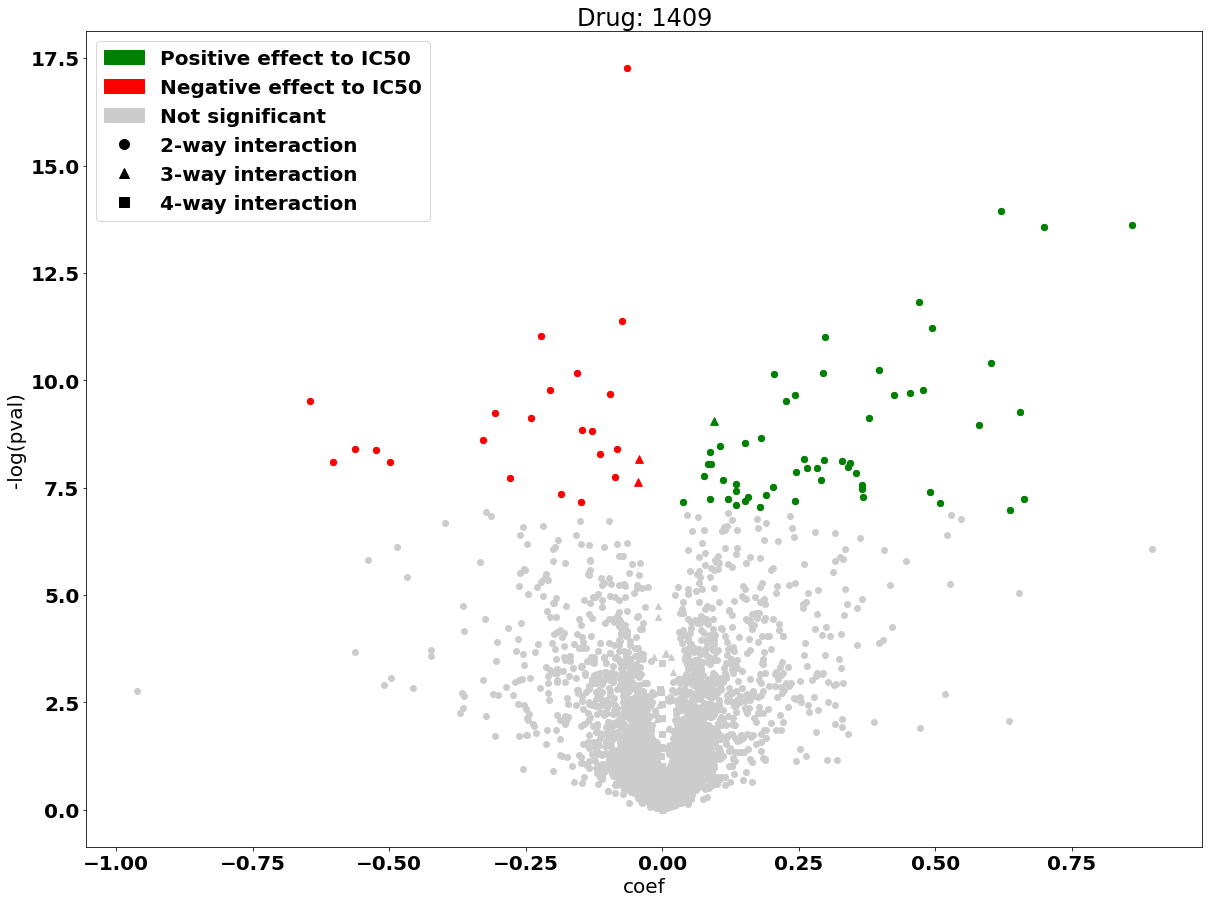

/var/folders/c5/g6ky3r7d2qjc07pmv0my66k80000gp/T/ipykernel_91749/837922940.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['significant'], _, threshold, _ = statsmodels.stats.multitest.multipletests(d['P>|z|'], 0.05, method='fdr_bh')
/var/folders/c5/g6ky3r7d2qjc07pmv0my66k80000gp/T/ipykernel_91749/837922940.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['significant'], _, threshold, _ = statsmodels.stats.multitest.multipletests(d['P>|z|'], 0.05, method='fdr_bh')
/var/folders/c5/g6ky3r7d2qjc07

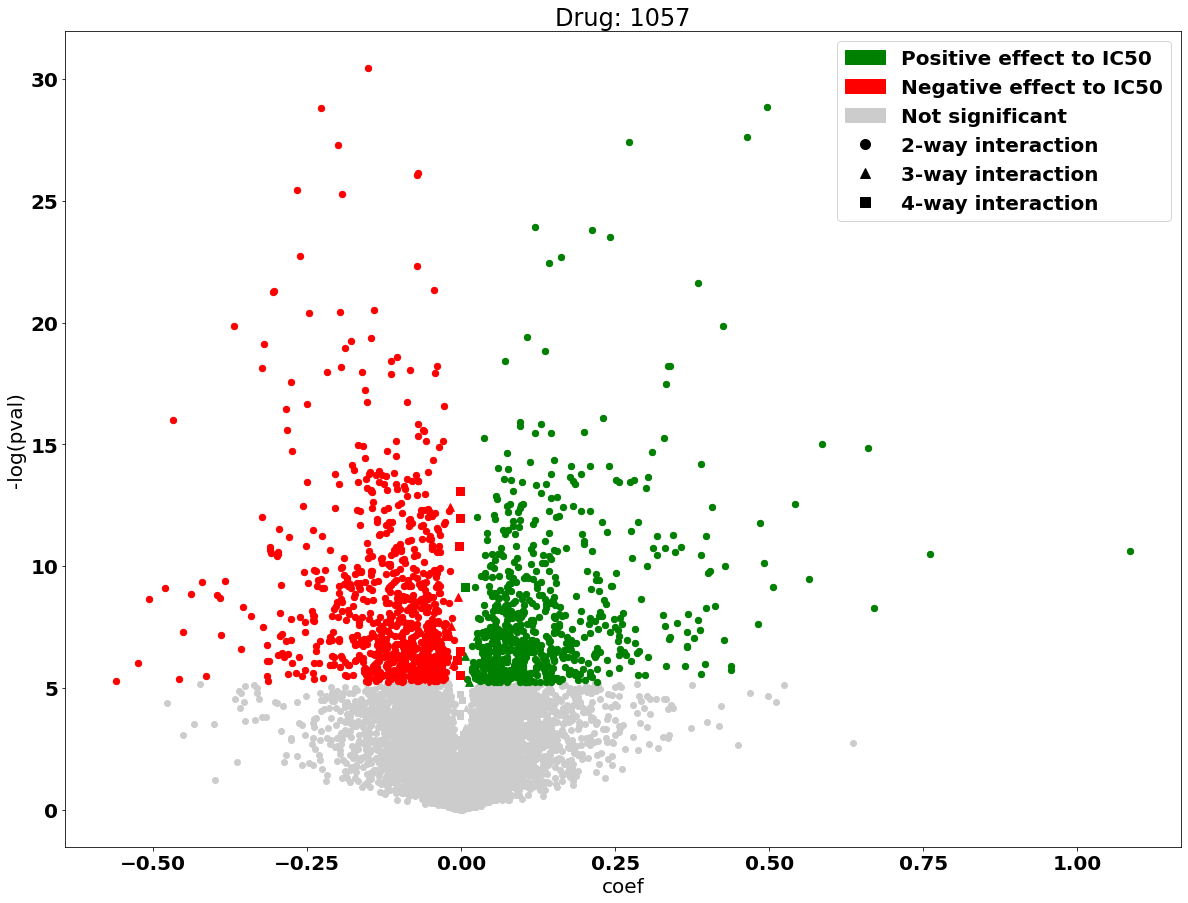

/var/folders/c5/g6ky3r7d2qjc07pmv0my66k80000gp/T/ipykernel_91749/837922940.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['significant'], _, threshold, _ = statsmodels.stats.multitest.multipletests(d['P>|z|'], 0.05, method='fdr_bh')
/var/folders/c5/g6ky3r7d2qjc07pmv0my66k80000gp/T/ipykernel_91749/837922940.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['significant'], _, threshold, _ = statsmodels.stats.multitest.multipletests(d['P>|z|'], 0.05, method='fdr_bh')
/var/folders/c5/g6ky3r7d2qjc07

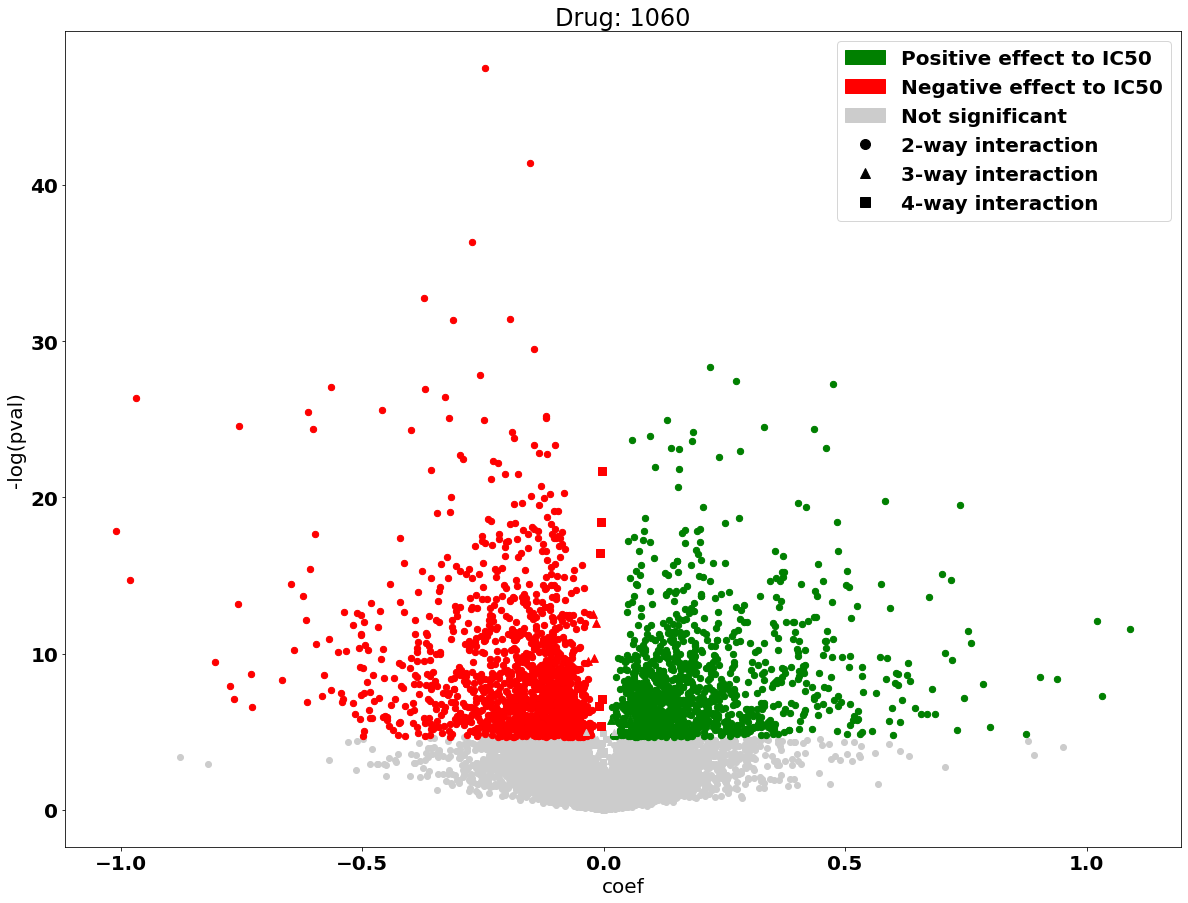

/var/folders/c5/g6ky3r7d2qjc07pmv0my66k80000gp/T/ipykernel_91749/837922940.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['significant'], _, threshold, _ = statsmodels.stats.multitest.multipletests(d['P>|z|'], 0.05, method='fdr_bh')
/var/folders/c5/g6ky3r7d2qjc07pmv0my66k80000gp/T/ipykernel_91749/837922940.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['significant'], _, threshold, _ = statsmodels.stats.multitest.multipletests(d['P>|z|'], 0.05, method='fdr_bh')
/var/folders/c5/g6ky3r7d2qjc07

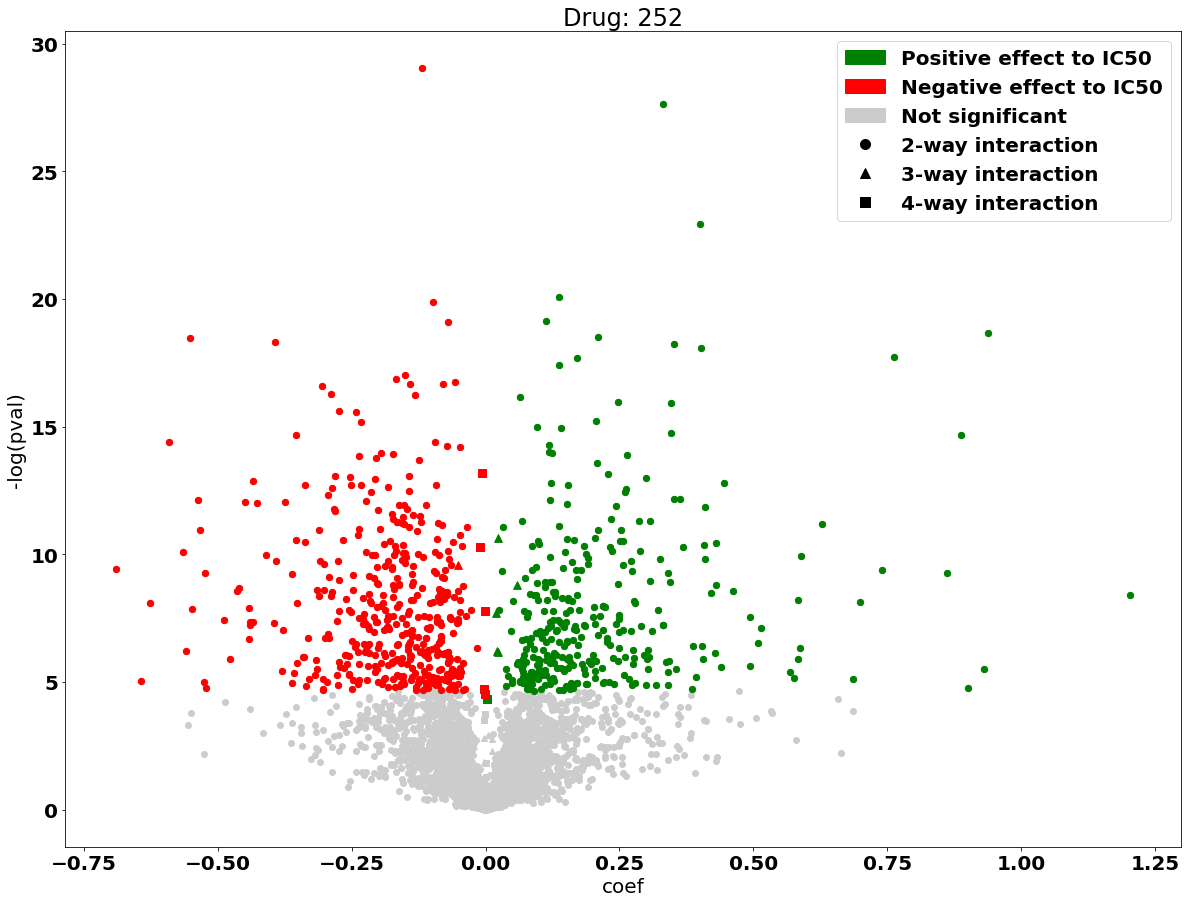

/var/folders/c5/g6ky3r7d2qjc07pmv0my66k80000gp/T/ipykernel_91749/837922940.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['significant'], _, threshold, _ = statsmodels.stats.multitest.multipletests(d['P>|z|'], 0.05, method='fdr_bh')
/var/folders/c5/g6ky3r7d2qjc07pmv0my66k80000gp/T/ipykernel_91749/837922940.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['significant'], _, threshold, _ = statsmodels.stats.multitest.multipletests(d['P>|z|'], 0.05, method='fdr_bh')
/var/folders/c5/g6ky3r7d2qjc07

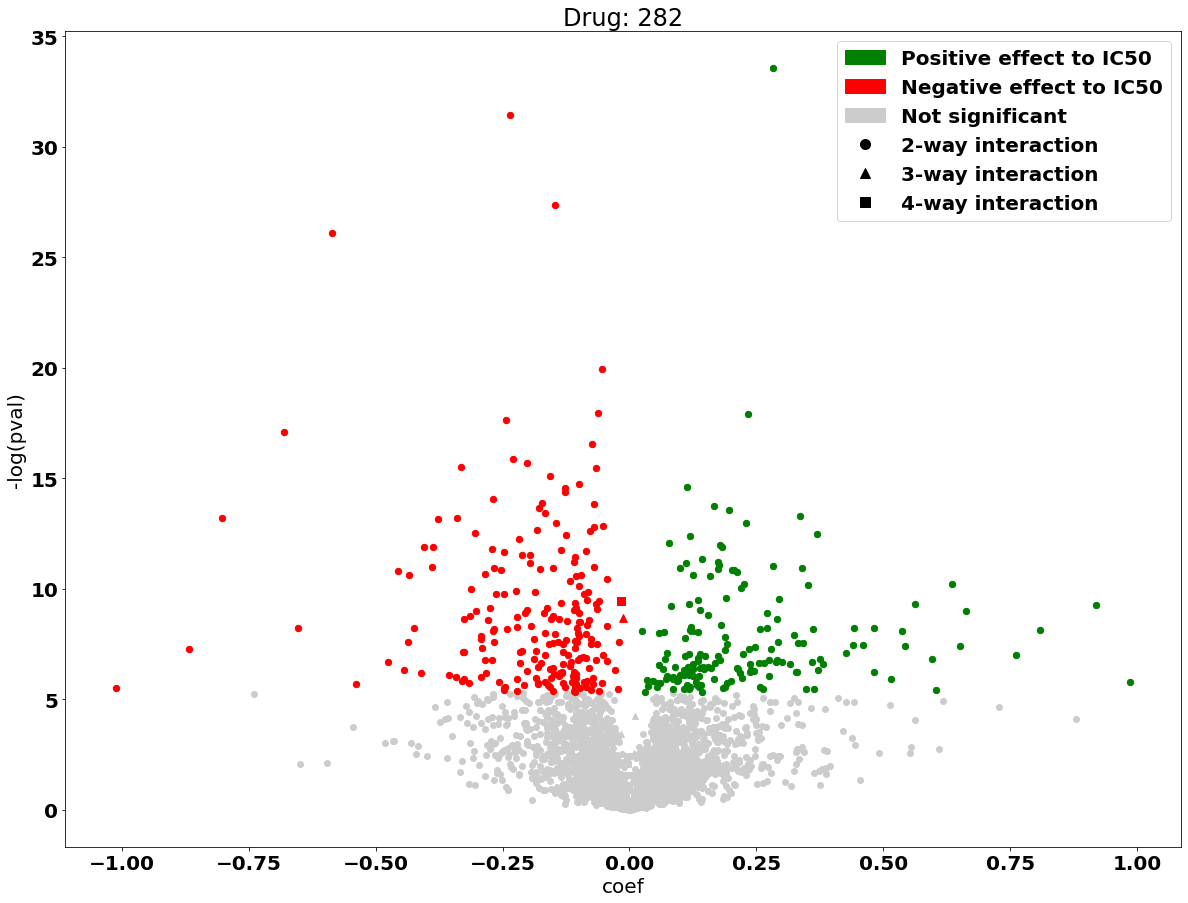

In [75]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

plt.rcParams['figure.figsize'] = [20, 15]
matplotlib.rc('font', **{'size'   : 20})

for elm in final_results.drug.unique():
    for i in range(1,4):
        d = final_results[(final_results.drug == elm) & (final_results.coef_id.apply(lambda x: x.count(':')==i))]
        d['significant'], _, threshold, _ = statsmodels.stats.multitest.multipletests(d['P>|z|'], 0.05, method='fdr_bh')

        if i==1: marker = 'o'
        elif i==2: marker='^'
        elif i==3: marker='s'
        else: marker='p'
        plt.scatter(d.coef, -d['P>|z|'].apply(np.log), marker=marker, c='0.8')
        mask = d.significant & (d.coef>0)
        plt.scatter(d[mask].coef, -d[mask]['P>|z|'].apply(np.log), marker=marker, c='g', s=i*20+20)
        mask = d.significant & (d.coef.astype(float)<0)
        plt.scatter(d[mask].coef, -d[mask]['P>|z|'].apply(np.log), marker=marker, c='r', s=i*20+20)
    
    
    red_patch = mpatches.Patch(color='r', label='Negative effect to IC50')
    green_patch = mpatches.Patch(color='g', label='Positive effect to IC50')
    gray_patch = mpatches.Patch(color='0.8', label='Not significant')
    o_marker = mlines.Line2D([], [], color='black', marker='o', linestyle='None',markersize=10, label='2-way interaction')
    c_marker = mlines.Line2D([], [], color='black', marker='^', linestyle='None',markersize=10, label='3-way interaction')
    s_marker = mlines.Line2D([], [], color='black', marker='s', linestyle='None',markersize=10, label='4-way interaction')

    
    plt.legend(handles=[green_patch, red_patch, gray_patch,o_marker,c_marker,s_marker])
    #plt.legend(loc="upper left")
    plt.title(f"Drug: {elm}")
    plt.xlabel('coef')
    plt.ylabel('-log(pval)')
    plt.show()


In [52]:
d[(d.coef<0)&].sort_values('P>|z|')

,coef_id,coef,std err,z,P>|z|,[0.025,0.975],converged,pseudo_r2,standard_fitting,snps,order,drug,significant
3,PaeaidANXAbHUMAN:QjYeFbFARPbHUMAN,-0.064537,0.012,-5.580311,3.191744e-08,-0.087235,-0.041839,889,0.075004,True,P04083.ANXA1_HUMAN+Q9Y4F1.FARP1_HUMAN,2,1409,True
3,PachgfFETUAHUMAN:PahjehYESHUMAN,-0.074571,0.017,-4.411799,1.151418e-05,-0.107745,-0.041397,889,0.023899,True,P02765.FETUA_HUMAN+P07947.YES_HUMAN,2,1409,True
3,PbdiaeETFAHUMAN:PbfjchRFAcHUMAN,-0.222598,0.051,-4.338078,1.602825e-05,-0.323306,-0.121889,889,0.026855,True,P13804.ETFA_HUMAN+P15927.RFA2_HUMAN,2,1409,True
3,PeigdhGSHBHUMAN:QjBPWiNIPSbHUMAN,-0.157174,0.038,-4.137234,3.850451e-05,-0.231735,-0.082613,889,0.034500,True,P48637.GSHB_HUMAN+Q9BPW8.NIPS1_HUMAN,2,1409,True
3,PcejciRPBbHUMAN:QjBVeaVAMPiHUMAN,-0.204971,0.051,-4.043266,5.730471e-05,-0.304467,-0.105476,889,0.029647,True,P24928.RPB1_HUMAN+Q9BV40.VAMP8_HUMAN,2,1409,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,PfdficMAPbbHUMAN:QjNZWfPALScHUMAN,-0.000132,0.048,-0.002760,9.977982e-01,-0.094081,0.093817,889,0.015967,True,P53582.MAP11_HUMAN+Q9NZW5.PALS2_HUMAN,2,1409,False
3,QfJTJdCOAgHUMAN:QjUNNfFAFbHUMAN,-0.000069,0.032,-0.002187,9.982559e-01,-0.061909,0.061771,889,0.006016,True,Q5JTJ3.COA6_HUMAN+Q9UNN5.FAF1_HUMAN,2,1409,False
3,QiWZAaLZICHUMAN:QjdagcRBPMSHUMAN,-0.000011,0.019,-0.000554,9.995581e-01,-0.037363,0.037342,889,0.001184,True,Q8WZA0.LZIC_HUMAN+Q93062.RBPMS_HUMAN,2,1409,False
3,PechaeLPPRCHUMAN:QjBTajCNPYdHUMAN,-0.000023,0.060,-0.000377,9.996992e-01,-0.117339,0.117294,889,0.006407,True,P42704.LPPRC_HUMAN+Q9BT09.CNPY3_HUMAN,2,1409,False


In [91]:
d = final_results[(final_results.drug == 282) & (final_results.coef_id.apply(lambda x: x.count(':')==1))]
d['significant'], _, threshold, _ = statsmodels.stats.multitest.multipletests(d['P>|z|'], 0.05, method='fdr_bh')
d[d.significant].sort_values('coef')


# TO STUDY FURTHER: P09012.SNRPA_HUMAN+Q9BW27.NUP85_HUMAN



/var/folders/c5/g6ky3r7d2qjc07pmv0my66k80000gp/T/ipykernel_91749/1152339719.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['significant'], _, threshold, _ = statsmodels.stats.multitest.multipletests(d['P>|z|'], 0.05, method='fdr_bh')


,coef_id,coef,std err,z,P>|z|,[0.025,0.975],converged,pseudo_r2,standard_fitting,snps,order,drug,significant
3,PajabcSNRPAHUMAN:QjgSTdSINdAHUMAN,-1.012064,0.350,-2.889314,3.955741e-03,-1.699544,-0.324585,883,0.015053,True,P09012.SNRPA_HUMAN+Q96ST3.SIN3A_HUMAN,2,282,True
3,PfebdgSYRCHUMAN:QbgijbMICgaHUMAN,-0.866752,0.254,-3.405781,6.896503e-04,-1.366240,-0.367265,883,0.031593,True,P54136.SYRC_HUMAN+Q16891.MIC60_HUMAN,2,282,True
3,OhfedjMPPBHUMAN:PefiiaVDACcHUMAN,-0.802791,0.167,-4.805912,1.811162e-06,-1.130639,-0.474942,883,0.043541,True,O75439.MPPB_HUMAN+P45880.VDAC2_HUMAN,2,282,True
3,QjNXeaOCADbHUMAN:QjUJZbSTMLcHUMAN,-0.680006,0.122,-5.551295,3.755468e-08,-0.920423,-0.439589,883,0.043863,True,Q9NX40.OCAD1_HUMAN+Q9UJZ1.STML2_HUMAN,2,282,True
3,PgcdbiSMDdHUMAN:PgdchjUBCjHUMAN,-0.653189,0.179,-3.654879,2.725618e-04,-1.003951,-0.302427,883,0.031961,True,P62318.SMD3_HUMAN+P63279.UBC9_HUMAN,2,282,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,PfbbejRABhAHUMAN:PfejcaSNAAHUMAN,0.662573,0.172,3.852588,1.253691e-04,0.325031,1.000115,883,0.035120,True,P51149.RAB7A_HUMAN+P54920.SNAA_HUMAN,2,282,True
3,QahgggKHDRbHUMAN:QiNFHfNUPdfHUMAN,0.761480,0.229,3.324992,9.208135e-04,0.311996,1.210964,883,0.020054,True,Q07666.KHDR1_HUMAN+Q8NFH5.NUP35_HUMAN,2,282,True
3,QjUPTiZCdHeHUMAN:QjYcQjRTciHUMAN,0.808296,0.222,3.641470,2.869366e-04,0.372644,1.243949,883,0.036660,True,Q9UPT8.ZC3H4_HUMAN+Q9Y2Q9.RT28_HUMAN,2,282,True
3,PajabcSNRPAHUMAN:QjBWchNUPifHUMAN,0.919530,0.234,3.926661,9.287348e-05,0.459921,1.379140,883,0.022873,True,P09012.SNRPA_HUMAN+Q9BW27.NUP85_HUMAN,2,282,True


In [93]:
so = x[['Cell_Line','P09012.SNRPA_HUMAN','Q9BW27.NUP85_HUMAN']].merge(y[y[column_to_group]==282], left_on='Cell_Line', right_on='cell_line_name')
so

,Cell_Line,P09012.SNRPA_HUMAN,Q9BW27.NUP85_HUMAN,drug_id,cell_line_name,ln_IC50
0,TE-12,6.786757,2.901278,282,TE-12,-0.995787
1,TMK-1,6.431369,2.806676,282,TMK-1,4.337301
2,PL4,6.270821,3.018600,282,PL4,4.165448
3,PCI-30,6.388265,3.395340,282,PCI-30,3.074261
4,HSC-39,6.052209,2.250701,282,HSC-39,1.182118
...,...,...,...,...,...,...
878,Ramos-2G6-4C10,6.706405,2.342739,282,Ramos-2G6-4C10,1.309326
879,CGTH-W-1,6.733070,0.000000,282,CGTH-W-1,2.130357
880,H9,6.683173,2.945941,282,H9,0.369390
881,GR-ST,6.580677,2.947407,282,GR-ST,1.298020


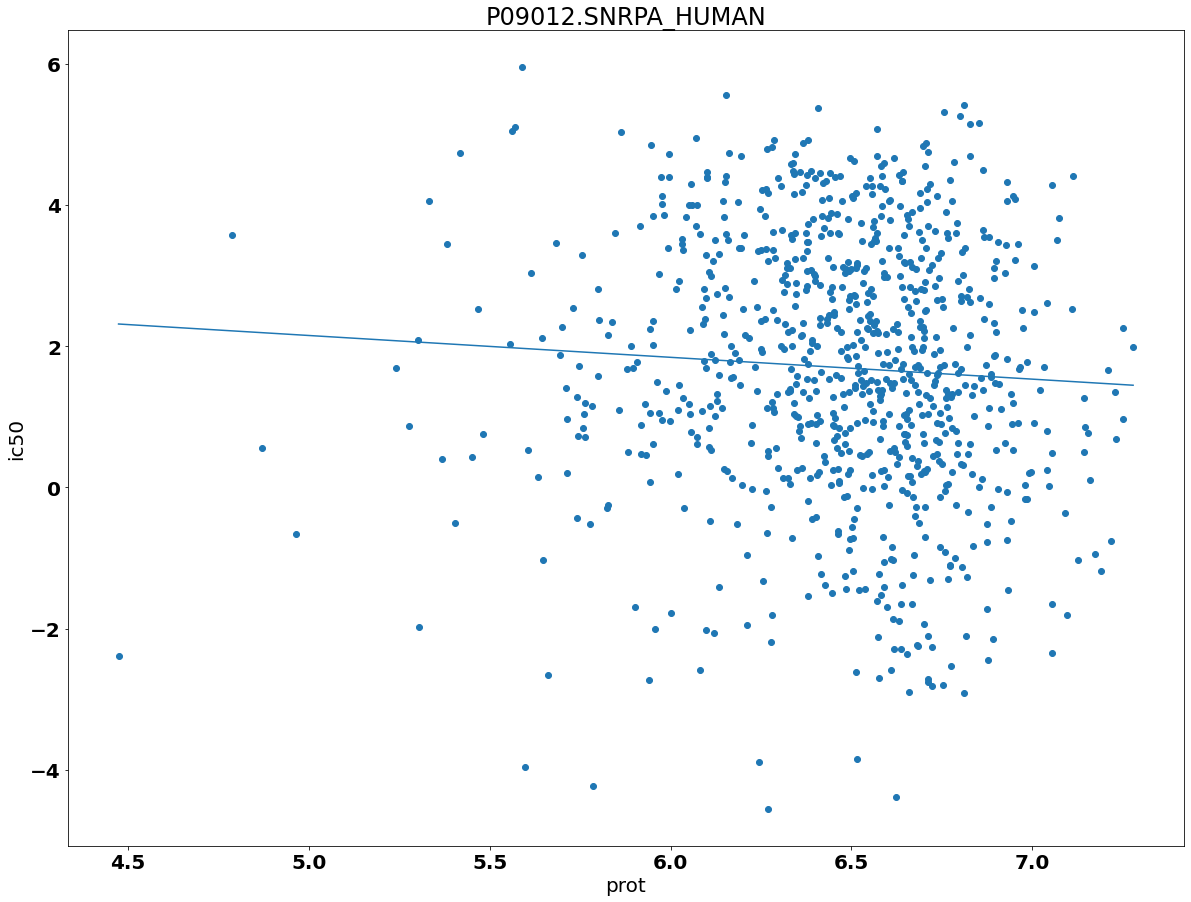

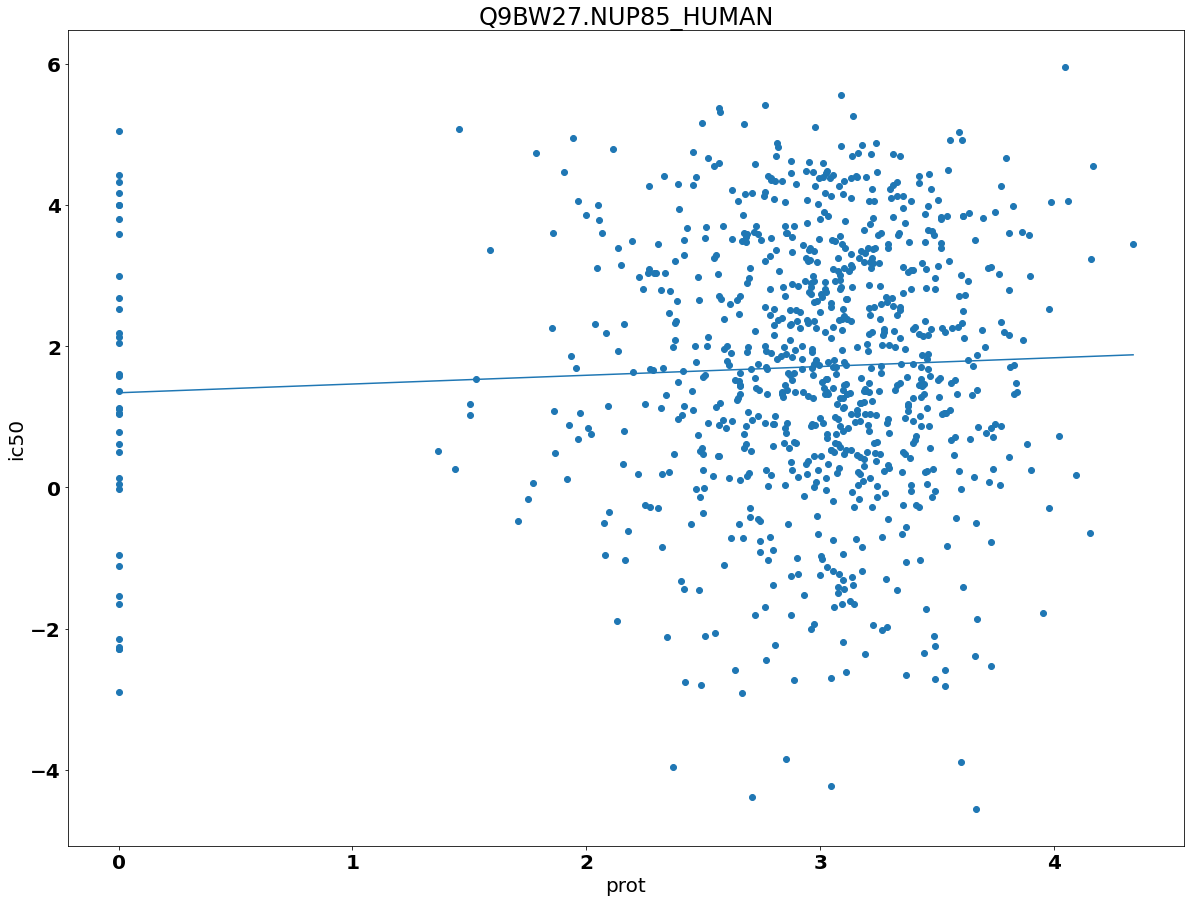

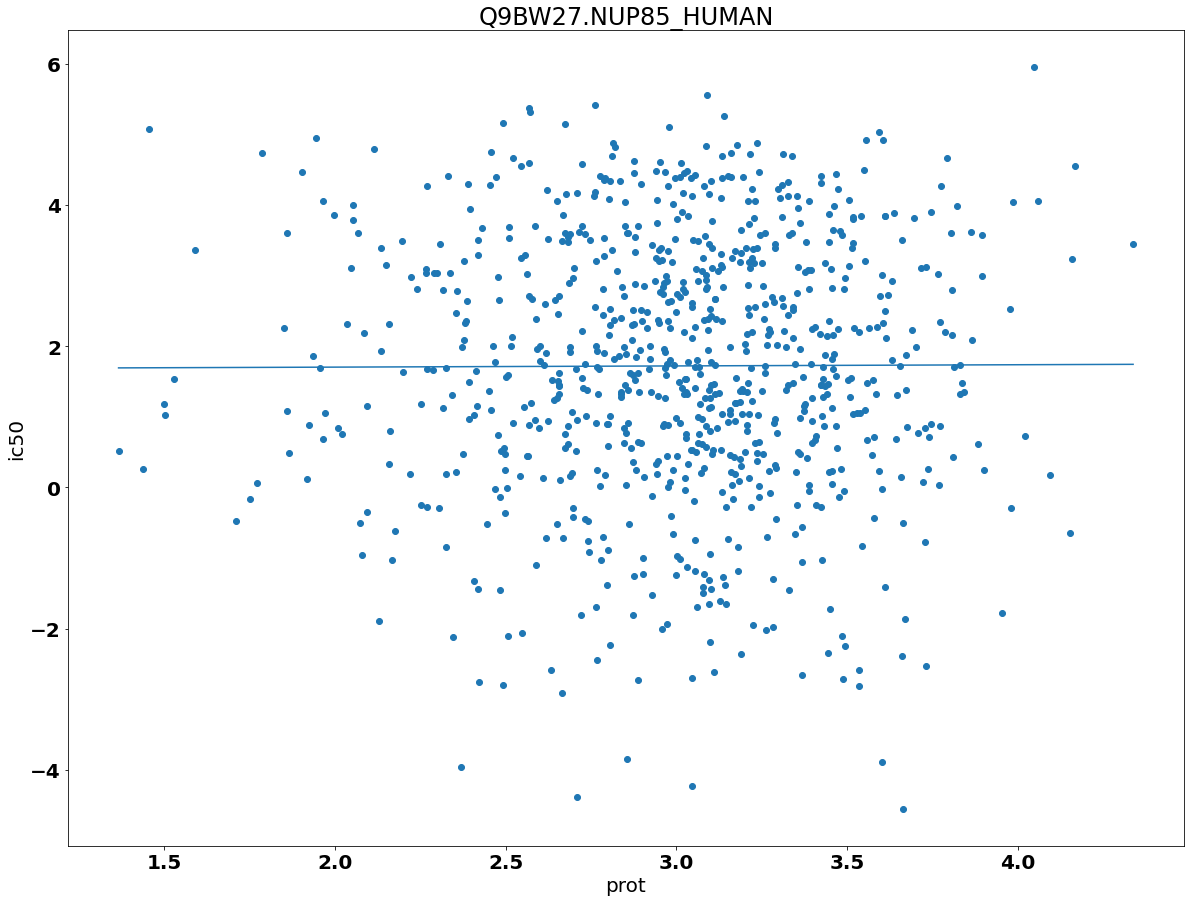

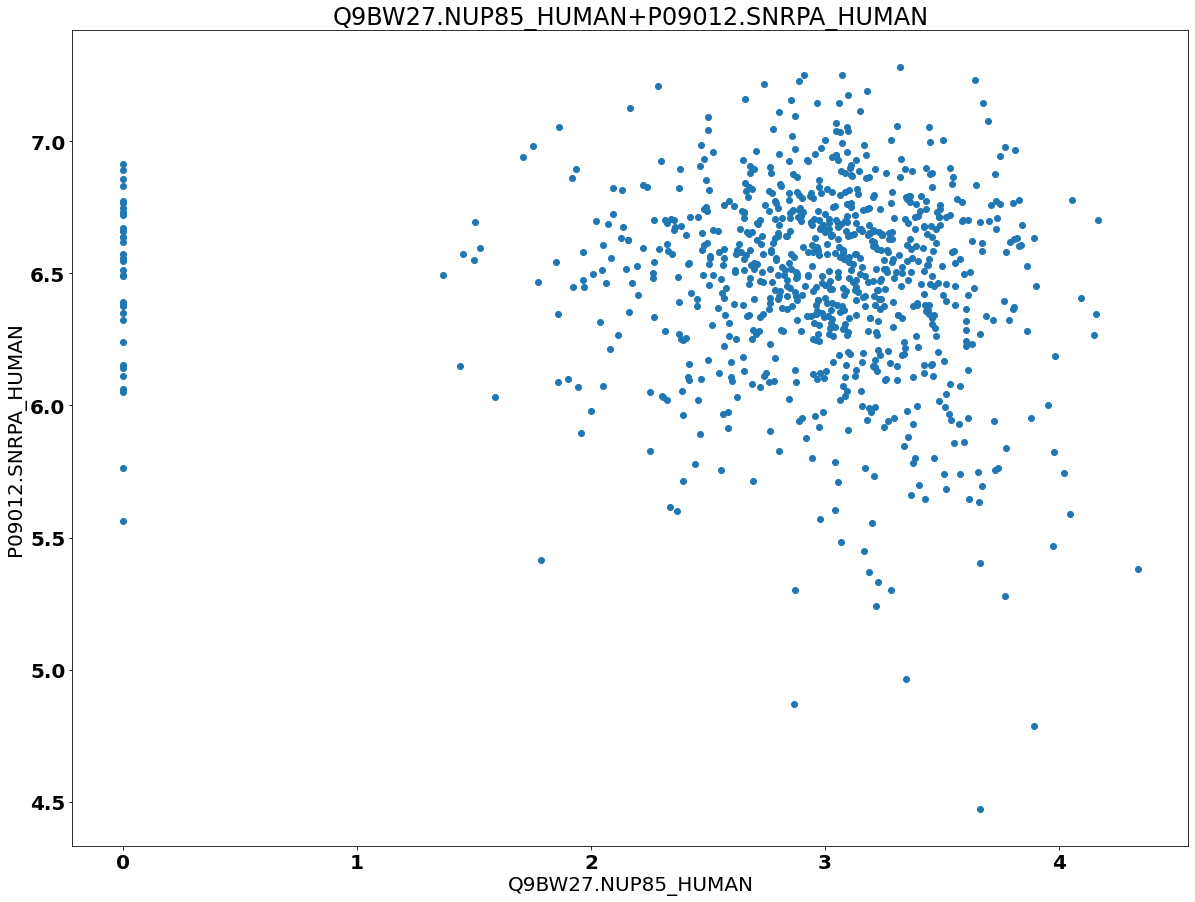

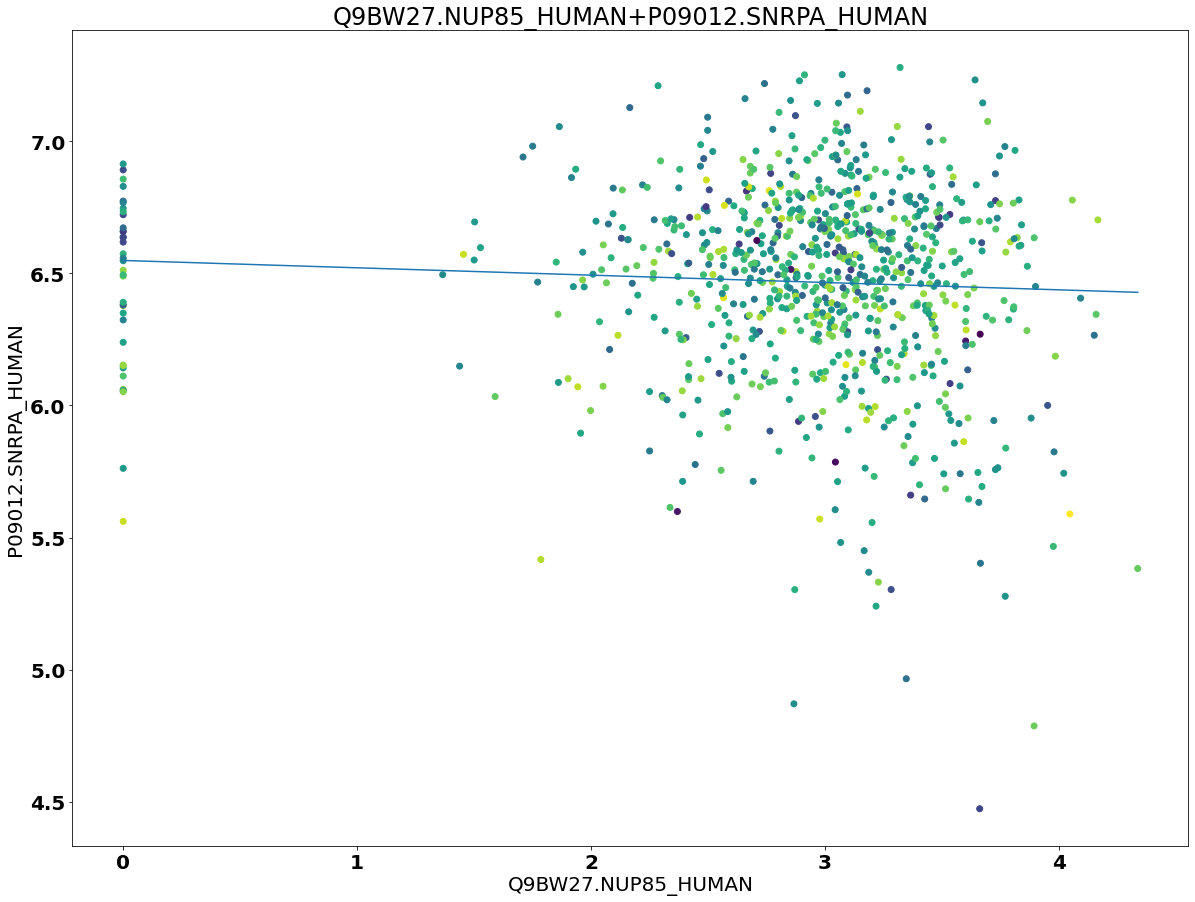

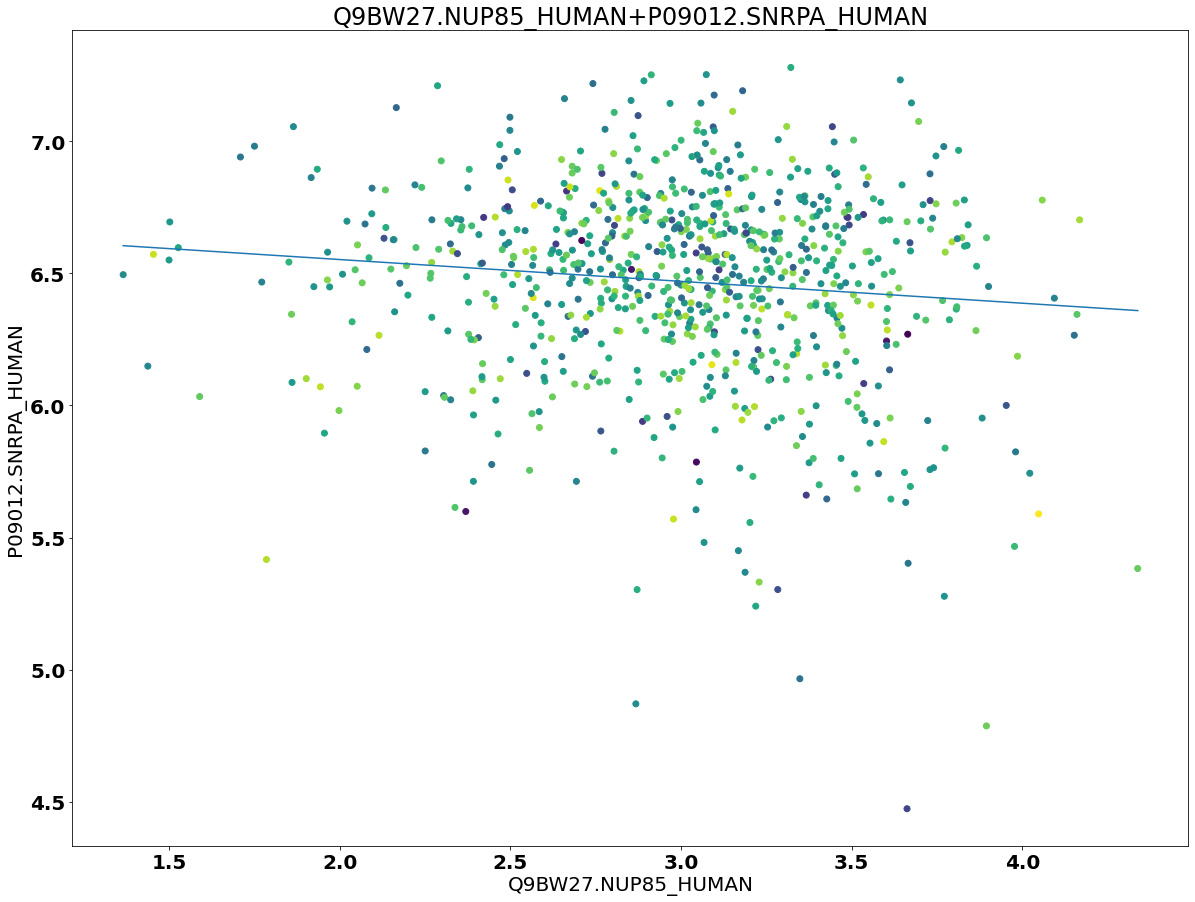

In [116]:
so = x[['Cell_Line','P09012.SNRPA_HUMAN','Q9BW27.NUP85_HUMAN']].merge(y[y[column_to_group]==282], left_on='Cell_Line', right_on='cell_line_name')

plt.scatter(so['P09012.SNRPA_HUMAN'], so['ln_IC50'])
plt.title('P09012.SNRPA_HUMAN')
plt.plot(np.unique(so['P09012.SNRPA_HUMAN']), np.poly1d(np.polyfit(so['P09012.SNRPA_HUMAN'], so['ln_IC50'], 1))(np.unique(so['P09012.SNRPA_HUMAN'])))
plt.xlabel('prot')
plt.ylabel('ic50')
plt.show()


plt.scatter(so['Q9BW27.NUP85_HUMAN'], so['ln_IC50'])
plt.plot(np.unique(so['Q9BW27.NUP85_HUMAN']), np.poly1d(np.polyfit(so['Q9BW27.NUP85_HUMAN'], so['ln_IC50'], 1))(np.unique(so['Q9BW27.NUP85_HUMAN'])))
plt.title('Q9BW27.NUP85_HUMAN')
plt.xlabel('prot')
plt.ylabel('ic50')
plt.show()

soo = so[so['Q9BW27.NUP85_HUMAN'] != 0]
plt.scatter(soo['Q9BW27.NUP85_HUMAN'], soo['ln_IC50'])
plt.plot(np.unique(soo['Q9BW27.NUP85_HUMAN']), np.poly1d(np.polyfit(soo['Q9BW27.NUP85_HUMAN'], soo['ln_IC50'], 1))(np.unique(soo['Q9BW27.NUP85_HUMAN'])))
plt.title('Q9BW27.NUP85_HUMAN')
plt.xlabel('prot')
plt.ylabel('ic50')
plt.show()

plt.scatter(so['Q9BW27.NUP85_HUMAN'], so['P09012.SNRPA_HUMAN'])
plt.title('Q9BW27.NUP85_HUMAN+P09012.SNRPA_HUMAN')
plt.xlabel('Q9BW27.NUP85_HUMAN')
plt.ylabel('P09012.SNRPA_HUMAN')
plt.show()


plt.scatter(so['Q9BW27.NUP85_HUMAN'], so['P09012.SNRPA_HUMAN'], c=so['ln_IC50']/6)
plt.title('Q9BW27.NUP85_HUMAN+P09012.SNRPA_HUMAN')
plt.xlabel('Q9BW27.NUP85_HUMAN')
plt.ylabel('P09012.SNRPA_HUMAN')
plt.plot(np.unique(so['Q9BW27.NUP85_HUMAN']), np.poly1d(np.polyfit(so['Q9BW27.NUP85_HUMAN'], so['P09012.SNRPA_HUMAN'], 1))(np.unique(so['Q9BW27.NUP85_HUMAN'])))
plt.show()


so = so[so['Q9BW27.NUP85_HUMAN'] != 0]
plt.scatter(so['Q9BW27.NUP85_HUMAN'], so['P09012.SNRPA_HUMAN'], c=so['ln_IC50']/6)
plt.title('Q9BW27.NUP85_HUMAN+P09012.SNRPA_HUMAN')
plt.xlabel('Q9BW27.NUP85_HUMAN')
plt.ylabel('P09012.SNRPA_HUMAN')
plt.plot(np.unique(so['Q9BW27.NUP85_HUMAN']), np.poly1d(np.polyfit(so['Q9BW27.NUP85_HUMAN'], so['P09012.SNRPA_HUMAN'], 1))(np.unique(so['Q9BW27.NUP85_HUMAN'])))
plt.show()

Q9BW27.NUP85_HUMAN,0.000000,1.366220,1.438423,1.454903,1.500605,1.502761,1.527598,1.590288,1.709652,1.750758,...,3.980171,3.985725,4.021669,4.047567,4.058224,4.093564,4.151951,4.159905,4.167623,4.337838
P09012.SNRPA_HUMAN,,,,,,,,,,,,,,,,,,,,,
4.473550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4.786953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4.870619,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4.965560,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5.240358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7.228711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7.232163,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7.251442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


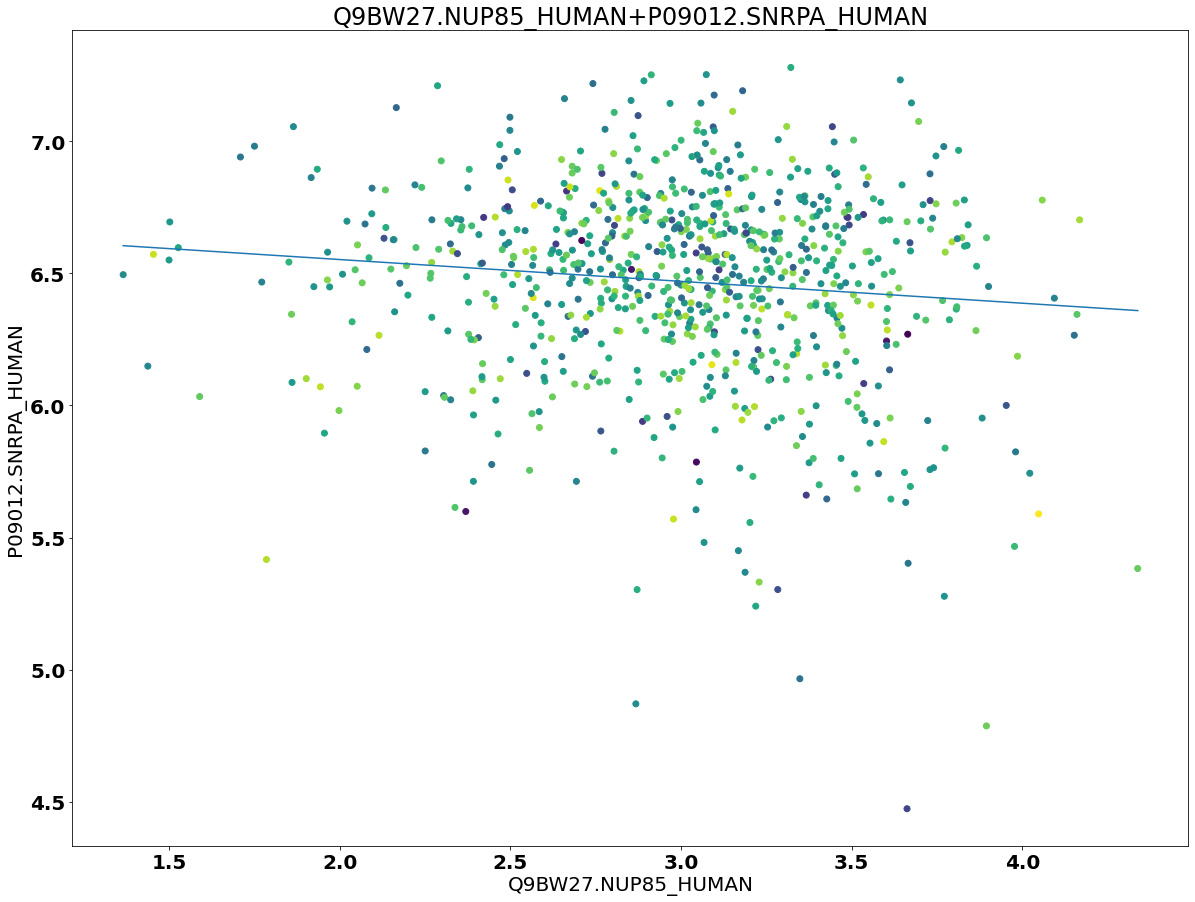

In [109]:
so = so[so['Q9BW27.NUP85_HUMAN'] != 0]
plt.scatter(so['Q9BW27.NUP85_HUMAN'], so['P09012.SNRPA_HUMAN'], c=so['ln_IC50']/6)
plt.title('Q9BW27.NUP85_HUMAN+P09012.SNRPA_HUMAN')
plt.xlabel('Q9BW27.NUP85_HUMAN')
plt.ylabel('P09012.SNRPA_HUMAN')
plt.plot(np.unique(so['Q9BW27.NUP85_HUMAN']), np.poly1d(np.polyfit(so['Q9BW27.NUP85_HUMAN'], so['P09012.SNRPA_HUMAN'], 1))(np.unique(so['Q9BW27.NUP85_HUMAN'])))
plt.show()

In [120]:
xy[['Cell_Line', 'P09012.SNRPA_HUMAN', 'Q9BW27.NUP85_HUMAN', 'drug_id', 'cell_line_name', 'ln_IC50']]

,Cell_Line,P09012.SNRPA_HUMAN,Q9BW27.NUP85_HUMAN,drug_id,cell_line_name,ln_IC50
0,TE-12,6.786757,2.901278,282,TE-12,-0.995787
1,TMK-1,6.431369,2.806676,282,TMK-1,4.337301
2,PL4,6.270821,3.018600,282,PL4,4.165448
3,PCI-30,6.388265,3.395340,282,PCI-30,3.074261
4,HSC-39,6.052209,2.250701,282,HSC-39,1.182118
...,...,...,...,...,...,...
878,Ramos-2G6-4C10,6.706405,2.342739,282,Ramos-2G6-4C10,1.309326
879,CGTH-W-1,6.733070,0.000000,282,CGTH-W-1,2.130357
880,H9,6.683173,2.945941,282,H9,0.369390
881,GR-ST,6.580677,2.947407,282,GR-ST,1.298020


In [122]:
drugs_list[:5][::-1]

array([ 282,  252, 1060, 1057, 1409])